<a href="https://colab.research.google.com/github/IEXE-Tec/computo-datos-masivos/blob/master/04_emr_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando Spark

No olvides cambiar la siguiente celda con la version de spark que quieras.
Las versiones ams recientes las puedes encontrar en el siguiente link:  
https://downloads.apache.org/spark/  



**Cuando hagas deployment en la nube o entres a produccion es muy importante que las versiones que utilices sean compatibles. Dado que Spark esta basado en Scala y utiliza librerias de Java es muy importante prestar atencion a las versiones!**

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirror.amaze.com.au/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
# En la siguiente celda necesitaremos la direccion donde esta instalado
# nuestra version de spark
!ls /content/

sample_data			 spark-2.4.7-bin-hadoop2.7.tgz.3
spark-2.4.7-bin-hadoop2.7	 spark-2.4.7-bin-hadoop2.7.tgz.4
spark-2.4.7-bin-hadoop2.7.tgz	 spark-2.4.7-bin-hadoop2.7.tgz.5
spark-2.4.7-bin-hadoop2.7.tgz.1  spark-warehouse
spark-2.4.7-bin-hadoop2.7.tgz.2




---



In [35]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()

In [36]:
import pyspark

Si no obtuvimos errores despues de esta celda todo se encuentra en orden.

# Hello World en Pyspark

## Creando el contexto de Spark

Primero creemos el **contexto de Pyspark**, que es necesario para cualquier programa que ejecutemos en Spark. La documentacion se encuentra en:  
https://www.tutorialspoint.com/pyspark/pyspark_sparkcontext.htm 


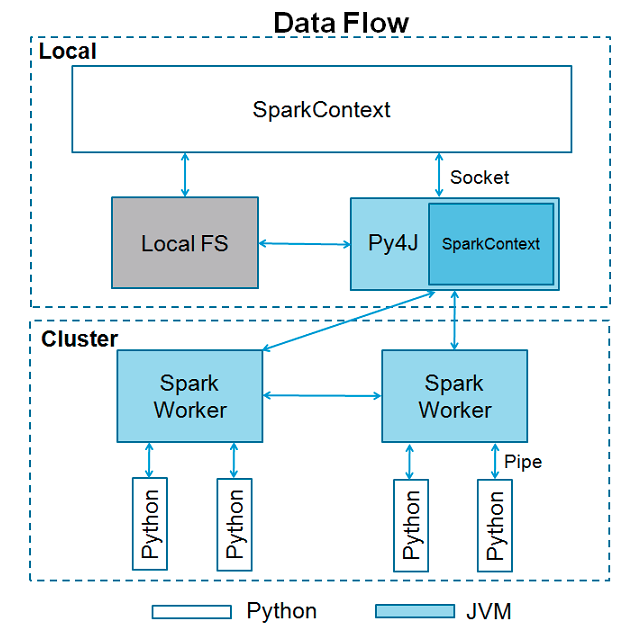

En este caso como no estamos en un cluster, correremos nuestra aplicacion de manera **local**. Por eso el primer parametro que apunta al nodo maestro es 'local', y el segundo es el nombre de la aplicacion. La documentacion de SparkContex se encuentra en:  
[Pyspark] https://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=parallelize#pyspark.SparkContext    

In [37]:
sc = pyspark.SparkContext(master="local", 
                          appName="hello_world")

ValueError: ignored

Trata de volver a correr la celda anterior. Obtendras un error, esto se debe a que en nuestro ambiente solo puede existir con contexto de Spark a la vez. Si deseas eliminarlo puedes hacer uso de:  


```
# sc por que asi se llama nuestra varaible
sc.stop()
```



## Creado un RDD

La documentacion del metodo parallelize se encuentra:  
[Scala] https://spark.apache.org/docs/2.1.1/programming-guide.html   
[Pyspark] https://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=parallelize#pyspark.SparkContext 

In [38]:
df = sc.parallelize(list("Hello World"))
df

AttributeError: ignored

El metodo `collect()` nos permite observar lo que tien nuestro objeto creado.  
**Collect (Action)** - Return all the elements of the dataset as an array at the driver program. This is usually useful after a filter or other operation that returns a sufficiently small subset of the data.



In [124]:
#df.collect()

Dado que spark proviene de Scala las operaciones y sintaxis que usa no son tan 'pythonicas'.  
Tiende a tener una estructura mas funcional.  
 **Ejercicio:** Contemos cuantos caracteres tiene de cada tipo tiene nuestra string Hello World.  

Primero separemos cada carecter, y otorguemosle un valor. En este caso como vamos a contar seria 1.  
Para ello podemos hacer uso de una tupla donde el primer elemento es el caracter, y el segundo su valor.  
Necesitaremos hacer uso de la funcion `map`, y la funcion anonima `lambda`.

In [ ]:
counter = df.map(lambda x: (x, 1))
counter.collect()

Este nuevo objeto `counter` lo podemos ver como una especie de diccionario, donde las llaves no son unicas. Por ejemplo, existen varias **l**.  
Lo que haremos a continuacion es aplicar una funcion u operador sobre las llaves `reduceByKey()`, es decir, los primeros elementos de la tupla. En este caso la funcion sera una suma o `add`.  
Idealmente este oeprador seria ejecuta simultaneamente alrededor de los nodos de nuestro cluster.

In [ ]:
# Importemos la libreria de operator y el operador 'add' o '+'
from operator import add
counter.reduceByKey(add).collect()

Observa como obtenemos una lista con el numero de veces que aprece cada caracter en nuestro string.  
Los metodos que aplicamos no son inplace.

In [ ]:
counter.collect()

Dado que Spark/Scala es **lazy eval** nuestro codigo no es evaluado hasta que es ejecutado. Ademas es importante notar que nuestro metodo `collect` es una accion no regresa un **RDD** sino una **lista**.

In [ ]:
counts = counter.reduceByKey(add).collect()
print(counter)
# Observa como counts ya no es un objeto como counter
print(counts)

Ahora ordenemos nuestro resultado por valor de aparicion:

In [ ]:
counter.reduceByKey(add).sortBy(lambda x: x[1],ascending=False).collect()

Pero, que pasa si aplicamos esta ultima linea de codigo directamente sobre nuestro objeto counter que ahota es una **lista**?

In [ ]:
counts = counter.reduceByKey(add).collect()
print(counts)
#counts.sortBy(lambda x: x[1],ascending=False).collect()

Obtenemos un error, pues la **lista** no tiene estos metodos.

**Ahora imprimamos nuestra lista**

In [ ]:
counts = counter.reduceByKey(add).sortBy(lambda x: x[1],
                                         ascending=False).collect()
for (word, count) in counts:
  print("{}: {}".format(word, count))



---



---



# ETL Playground Spark


## Creemos Spark Session


Las primeras versiones de Spark nos obligaban a crear un **contexto** para diferentes aplicaciones. Por ejemplo:
+ Spark Context
+ Hive Context
+ SQL Context
+ Streaming Context  

Las nuevas versiones, tienen un nuevo metodo conocido como **Spark Session**, que crea un **contexto** para todas las operaciones, incluyendo todas las antes mencionadas. En general para nuestros esfuerzos de ETL es mejor utilizar **Sessions**

Eliminemos el contexto anterior.


In [40]:
sc.stop()

Creemos un Spark Session para leer una base de datos en formato JSON.  
En este caso no existira el mismo problema que con los contextos. Pues las **sesiones** esta disennado para contener varios contextos.

In [41]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

sc = SparkSession \
        .builder \
        .appName("elt_json") \
        .getOrCreate()

## Leer datos

Ahora leamos directamente de github un archivo tipo csv desde pyspark.  
El archivo es un csv con la cabeza del proyecto que realizaremos mas tarde en EMR.

In [42]:
from pyspark import SparkFiles
# Agreguemos la direccion a nuestra sesion de spark
url = "https://raw.githubusercontent.com/IEXE-Tec/computo-datos-masivos/master/nano_sparkify_event_data.csv"
sc.sparkContext.addFile(url)

# Leamos nuestro archivo
df = sc.read.csv("file://"+SparkFiles.get("nano_sparkify_event_data.csv"),
                 header="true")

Miremos que contiene este data frame.


```
.show()
```



In [43]:
df.show()

+---+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+---------------+---------+--------------------+------+-------------+--------------------+--------------------+
|_c0|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page|   registration|sessionId|                song|status|           ts|           userAgent|              userId|
+---+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+---------------+---------+--------------------+------+-------------+--------------------+--------------------+
|  0|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000.0|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|                  30|
|  1|    Fiv

Toma unos momentos para analizar el data set.
De que parece ser?

## GroupBy

**Group By** en spark.  
Agrupemos por genero

In [44]:
gender = df.groupBy('gender').count()
print(gender.show())

+------+-----+
|gender|count|
+------+-----+
|     F|25187|
|  null| 1537|
|     M|23276|
+------+-----+

None


## SQL Queries

Analicemos la columna de **length** que contiene la duracion de las canciones.

In [45]:
# Creemos una tabla temporal
df.registerTempTable("length")
output =  sc.sql('SELECT length from length')
output.show()

+---------+
|   length|
+---------+
|277.89016|
|236.09424|
| 282.8273|
|262.71302|
|223.60771|
|208.29995|
|260.46649|
|185.44281|
|     null|
|134.47791|
| 229.8771|
|     null|
|223.58159|
|201.06404|
|     null|
|246.69995|
|168.64608|
| 166.1122|
|222.22322|
|229.77261|
+---------+
only showing top 20 rows



Veamos las observaciones donde la cacnion dura menos de 200 segundos.

In [46]:
output = sc.sql('SELECT * from length WHERE `length` < 200')
output.show()

+---+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------------+---------+--------------------+------+-------------+--------------------+--------------------+
|_c0|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|   registration|sessionId|                song|status|           ts|           userAgent|              userId|
+---+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------------+---------+--------------------+------+-------------+--------------------+--------------------+
|  7|        Starflyer 59|Logged In|    Colin|     M|           53| Freeman|185.44281| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000.0|       29|Passengers (Old A...|   200|1538352899000|Mozilla/5.0 (Wind...|                  30|
|  9|            Frumpies|Logged In|    

Ahora veamos cuantos usuarios por nivel existen.

In [47]:
output = sc.sql('SELECT COUNT(*) as total, level from length GROUP BY level')
output.show()

+-----+-----+
|total|level|
+-----+-----+
|16156| free|
|33844| paid|
+-----+-----+



## Spark RDD a Pandas

Podemos convertir facilmente cualquier data frame de Spark a Pandas.  
La desventaja es que al pasarse a Pandas se peirden todas las funcionalidades de Spark, por ejemplo el poder de computo distribuido.  

In [48]:
import pandas as pd
pandas_df = df.toPandas()
pandas_df

,_c0,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000.0,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000.0,8,Canada,200,1538352180000,"""""""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWe...",like Gecko) Chrome/37.0.2062.103 Safari/537.3...
2,2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.8273,paid,"Bakersfield, CA",PUT,NextSong,1538173362000.0,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000.0,8,Knocking On Forbidden Doors,200,1538352416000,"""""""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWe...",like Gecko) Chrome/37.0.2062.103 Safari/537.3...
4,4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000.0,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,Killswitch Engage,Logged In,Jadyn,M,72,Rose,269.06077,paid,"Austin-Round Rock, TX",PUT,NextSong,1535268719000.0,893,Let The Bridges Burn (Album Version),200,1539692813000,"""""""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWe...",like Gecko) Chrome/36.0.1985.143 Safari/537.3...
49996,49996,Kanye West,Logged In,Chayse,M,25,Keller,311.92771,paid,"Jackson, MS",PUT,NextSong,1529643103000.0,904,Stronger,200,1539692818000,"""""""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWe...",like Gecko) Chrome/37.0.2062.103 Safari/537.3...
49997,49997,Ill Nino,Logged In,Alyssa,F,22,Johnston,226.45506,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1532634173000.0,879,What Comes Around (Album Version),200,1539692826000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66
49998,49998,Marvin Gaye,Logged In,Kael,M,99,Baker,235.62404,paid,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000.0,885,I Want You,200,1539692834000,"""""""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9...","like Gecko) Version/7.0.5 Safari/537.77.4"""""""


# Sparkify nano

**Que es?**  
Sparkify es un set de datos publico que simula una compannia de streamig de musica, muy parecido a Spotify.

El dataset completo contiene 18 columnas mas de 286 mil lineas, y pesa mas de 11 GB, por lo que computadoras con poca memoria son incapaces de manejarlo eficientemente.

**Que tenemos que evaluar?**  
El objetico es realizar un analisis de CHURN (tasa de cancelacion de clientes). La idea es estimar la probabilidad de que un usuario cancele o cambie su suscripcion por una mas barata. por el servicio, basandonos en su historial.

**Utilidad**  
Si logramos estimar la probabilidad de que un usuario cancele su cuenta en el siguiente periodo no solo nos ayudaria a tener mejores estimaciones de ganancias, sino tambien a tratar de retenerlo con alguna politica (i.e descuento, mensaje, promociones ...). Ademas, podriamos encontrar que variables influyen en su CHURN.

**Sparkify nano**  
Antes de pasar a realizar el analisis haciendo uso de EMR y de todos los datos, es combeniente analizarlos en pequenna escala para crear un template (esqueleto) de lo que sera nuestro codigo.   
Puntualmente, analizaremos un subconjunto muy pequeno de los datos para darnos una idea de lo que esta ocurriendo.  

## ETL Sparkify nano

**Descripcion**  
Cada vez que un usuario interactua con la plataforma ya sea escuchando alguna cancion, haciendo log in/out, da like, etc... se generan datos. Esta es la base a la que tenemos acceso.  

Recuerda que no todas las columnas necesariamente nos seran de utilidad.

### Glimpse/vistazo a los datos

**Sugerencia**
Llena esta celda con una pequenna descripcion del significado de cada variable. Utiliza el analisis que realizaremos abajo.   

 |-- _c0:  
 |-- artist:   
 |-- auth:      
 |-- firstName:    
 |-- gender:   
 |-- itemInSession:   
 |-- lastName:   
 |-- length:   
 |-- level:   
 |-- location:   
 |-- method:   
 |-- page: **tipo de accion** que realiza el usuario.   
 |-- registration:   
 |-- sessionId:   
 |-- song:   
 |-- status:   
 |-- ts:   
 |-- userAgent:  
 |-- userId:  

In [49]:
# Veamos la estructura de los Datos
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: string (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Observa que tipo de dato es cada columna, y piensa si debe cambiarse o no.

In [50]:
# Observemos la priemra linea de nuestros datos
df.take(1)

[Row(_c0='0', artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession='50', lastName='Freeman', length='277.89016', level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration='1538173362000.0', sessionId='29', song='Rockpools', status='200', ts='1538352117000', userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [51]:
# Numero de Filas
print('Numero de filas: ', df.count())

# Numero de Columnas
print('Numero de columnas: ' ,len(df.columns))

Numero de filas:  50000
Numero de columnas:  19


A continuacion importaremos una serie de funciones que nos ayudaran a transformar y evaluar los datos. Si tienes alguna duda, te recomendamos revisar la documentacion.

### Analisis de campos vacios, NaNs, Nulls, etc...

In [52]:
# Numero de NaNs por columna
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min
from pyspark.sql.functions import max, sum, split, udf, isnan, when, count, countDistinct
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|_c0|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+---+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|  0|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+---+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [53]:
# Numero de Nulos por columna
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|_c0|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+---+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|  0| 10442|   0|     1537|  1537|            0|    1537| 10442|    0|    1537|     0|   0|        1537|        0|10442|     0|  0|     1537|  1537|
+---+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [54]:
# Numero de filas sin usuario o id
print('# filas sin id de usuario: ', df.filter(df.userId == "").count())
print('# filas sin id de sesion: ',df.filter(df.sessionId == "").count())

# filas sin id de usuario:  0
# filas sin id de sesion:  0


In [55]:
# Utilicemos solo las filas con ids
df = df.select("*").where((df.userId != ""))
df = df.select("*").where((df.sessionId != ""))
print('Numero de filas: ', df.count())

Numero de filas:  48463


### Analisis de columnas

In [56]:
# Revisemos que tipo de acciones ejecutan los usuarios
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [57]:
# Tu analisis

### Manejo de timestamps

**udf**  
A continuacion haremos uso de `udf` o 'users define functions'. Esta funcion nos permite definir funciones en terminos de python, para despues utilizarlas en RDDs de Spark, o en Spark SQL. La documentacion la presentamos a continuacion.  

https://docs.databricks.com/spark/latest/spark-sql/udf-python.html  



El formato de tiempo viene en milisegundos en formato UNIX time. En este tipo de bases de datos es muy comun encontrar este formato. Para saber mas puedes visitar:  
https://es.wikipedia.org/wiki/Tiempo_Unix 

In [123]:
from datetime import datetime
from pyspark.sql.functions import udf
    
# Creemos la funcion para cambiar tiempo unix a tiempo humano
unix_ts = udf(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

# Convertir la columna ts
df = df.withColumn("ts", df.ts/1000)
df = df.withColumn("ts", unix_ts(df.ts))
# Convertir la columna registration
df = df.withColumn("registration", df.registration/1000)
df = df.withColumn("registration", unix_ts(df.registration))

df.show()

+---+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------------+---------+--------------------+------+-------------------+--------------------+--------------------+
|_c0|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page|       registration|sessionId|                song|status|                 ts|           userAgent|              userId|
+---+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------------+---------+--------------------+------+-------------------+--------------------+--------------------+
|  0|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|2018-09-28 22:22:42|       29|           Rockpools|   200|2018-10-01 00:01:57|Mozilla/5.0 (Wi